In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Reading the data**

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
input_path="/content/drive/MyDrive/Data"
train_data = pd.read_csv("/content/drive/MyDrive/Data/train_final.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Data/test_final.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             25000 non-null  int64 
 1   workclass       25000 non-null  object
 2   fnlwgt          25000 non-null  int64 
 3   education       25000 non-null  object
 4   education.num   25000 non-null  int64 
 5   marital.status  25000 non-null  object
 6   occupation      25000 non-null  object
 7   relationship    25000 non-null  object
 8   race            25000 non-null  object
 9   sex             25000 non-null  object
 10  capital.gain    25000 non-null  int64 
 11  capital.loss    25000 non-null  int64 
 12  hours.per.week  25000 non-null  int64 
 13  native.country  25000 non-null  object
 14  income>50K      25000 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 2.9+ MB


**Handling Missing Value**

In [ ]:
# Replace missing values in 'workclass', 'occupation', and 'native.country' with mode in train dataset
workclass_mode = train_data['workclass'].mode()[0]
occupation_mode = train_data['occupation'].mode()[0]
native_country_mode = train_data['native.country'].mode()[0]

train_data['workclass']=train_data['workclass'].replace('?', workclass_mode)
train_data['occupation']=train_data['occupation'].replace('?', occupation_mode)
train_data['native.country']=train_data['native.country'].replace('?', native_country_mode)

# Replace missing values in the test dataset using the mode from the train dataset
test_data['workclass']=test_data['workclass'].replace('?', workclass_mode)
test_data['occupation']=test_data['occupation'].replace('?', occupation_mode)
test_data['native.country']=test_data['native.country'].replace('?', native_country_mode)

**Visualizing the Categorical Variables with Respect to the Target Variabl**

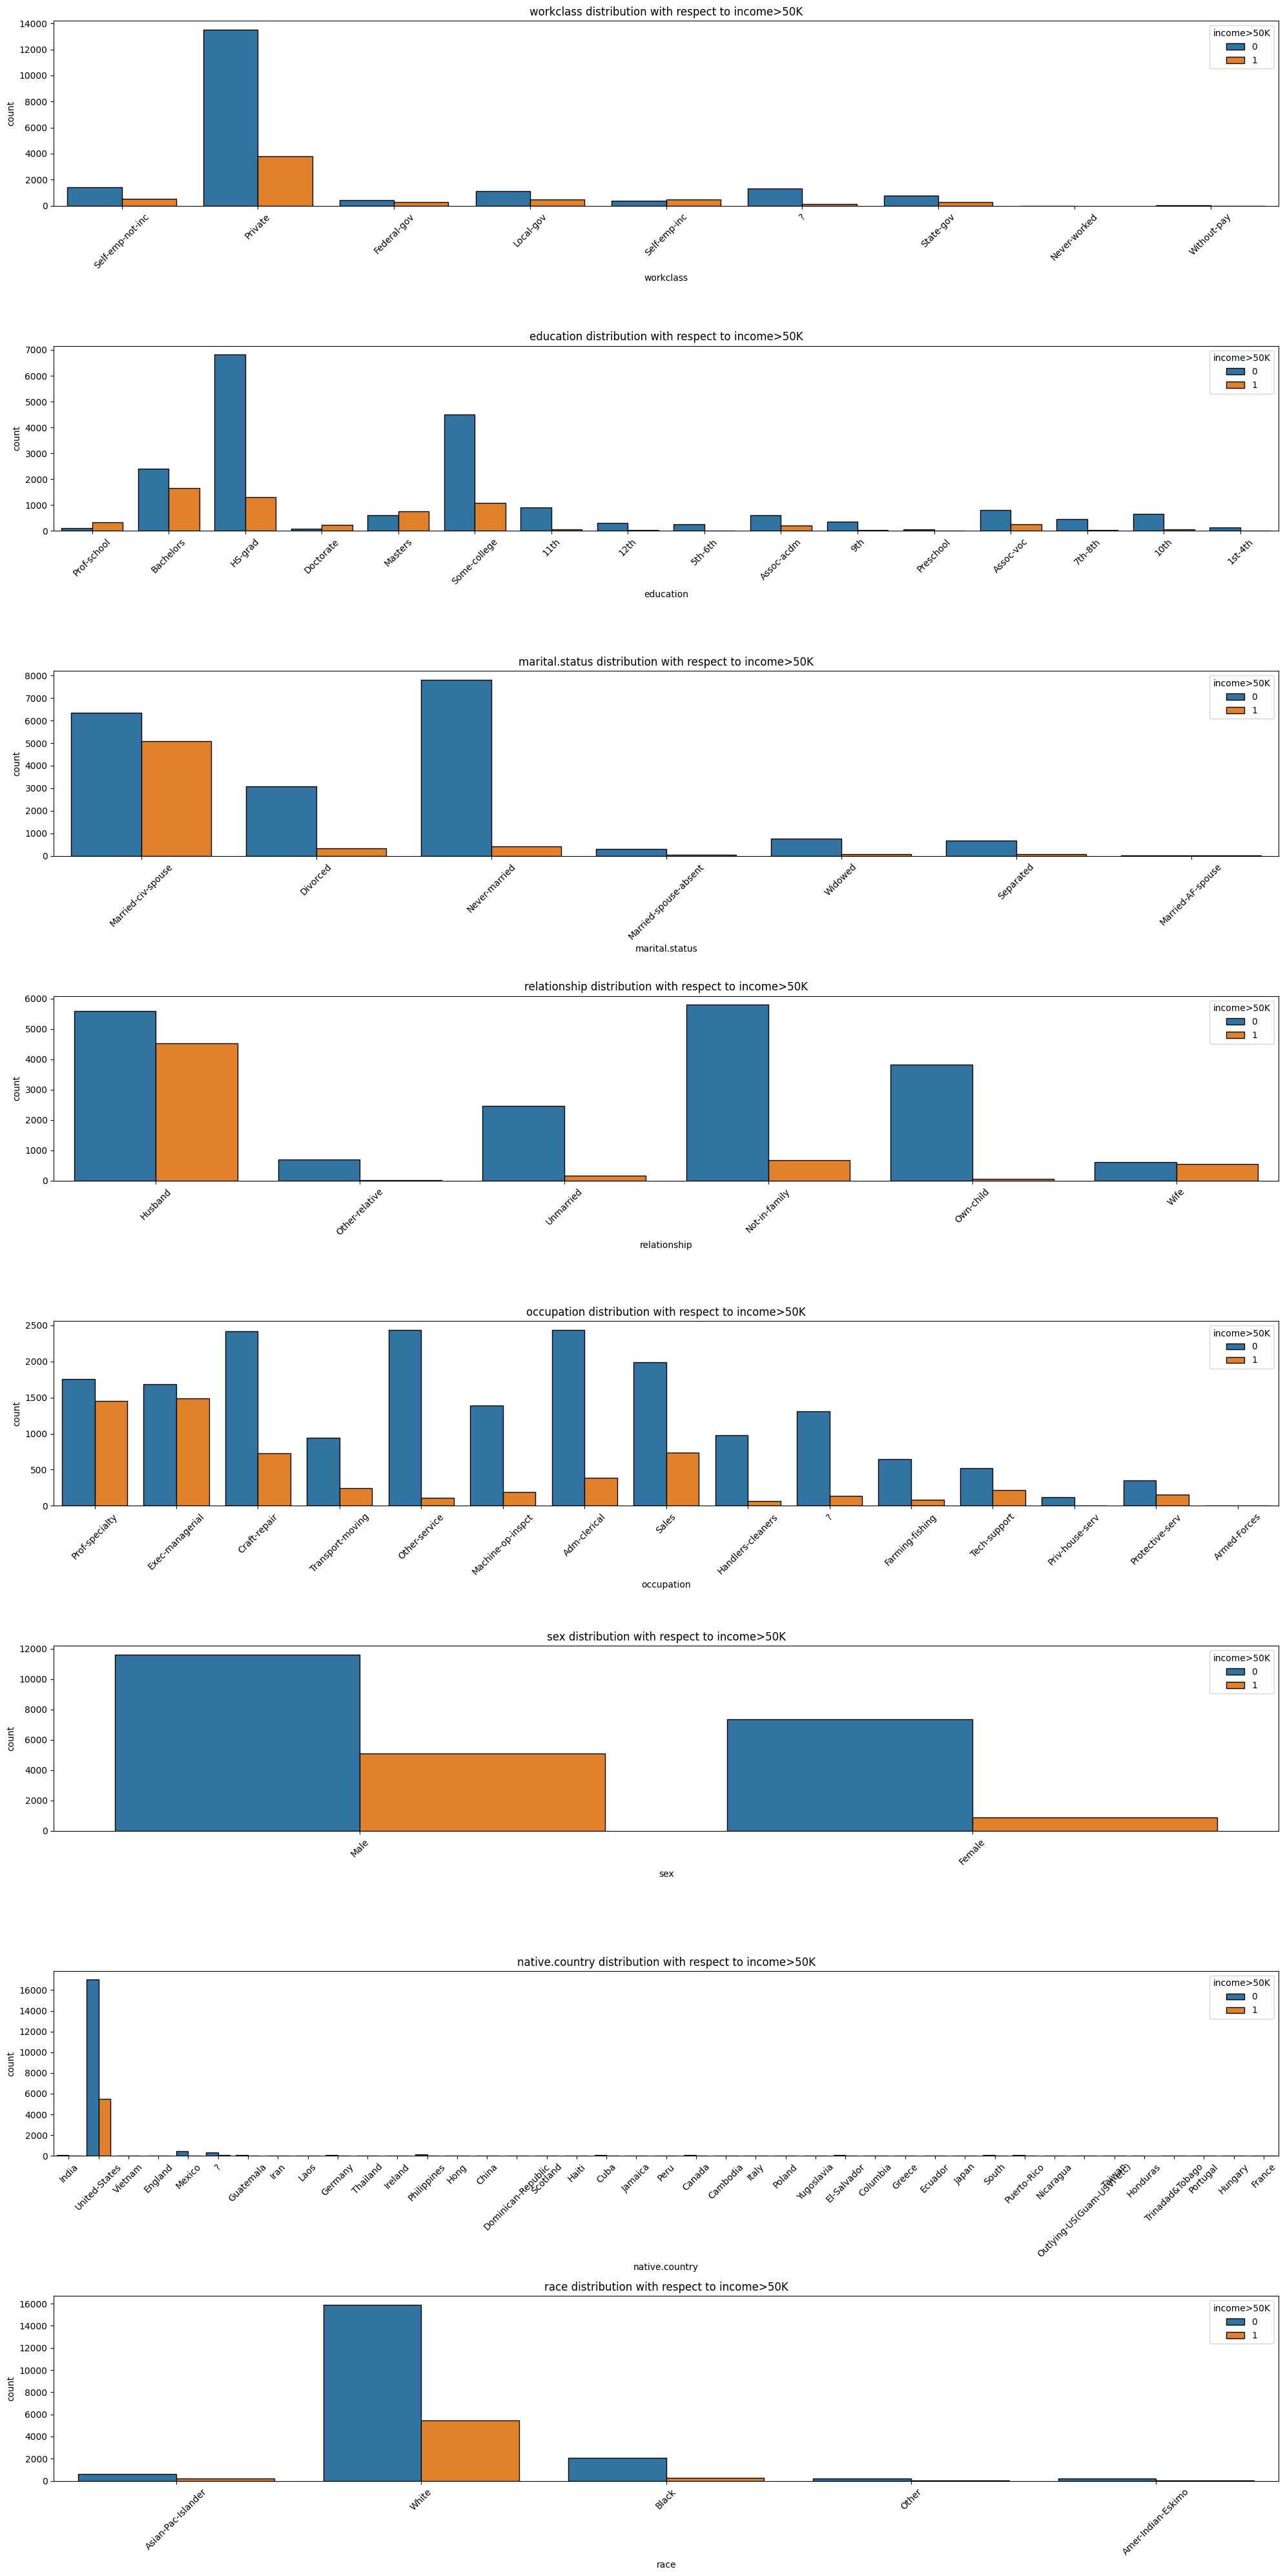

In [ ]:
def plot_categorical_with_income(df, categorical_columns, target):
    plt.figure(figsize=(20, len(categorical_columns) * 5))
    for i, col in enumerate(categorical_columns, 1):
        plt.subplot(len(categorical_columns), 1, i)
        sns.countplot(data=df, x=col, hue=target, edgecolor='black')
        plt.title(f'{col} distribution with respect to {target}')
        plt.xticks(rotation=45)
        plt.tight_layout()
    plt.show()

# Function to plot numerical features with respect to income
def plot_numerical_with_income(df, numerical_columns, target):
    plt.figure(figsize=(15, len(numerical_columns) * 5))
    for i, col in enumerate(numerical_columns, 1):
        plt.subplot(len(numerical_columns), 2, i)
        sns.boxplot(data=df, x=target, y=col)
        plt.title(f'{col} distribution with respect to {target}')
        plt.tight_layout()
    plt.show()

# Categorical columns to visualize
categorical_columns = ['workclass', 'education', 'marital.status', 'relationship', 'occupation', 'sex', 'native.country','race']
numerical_columns = ['age', 'fnlwgt', 'education.num', 'hours.per.week', 'capital.gain', 'capital.loss']
# Plotting categorical features with respect to 'income>50K'
plot_categorical_with_income(train_data, categorical_columns, 'income>50K')

**Visualziing the Numerical Variables with respect to Target variable**

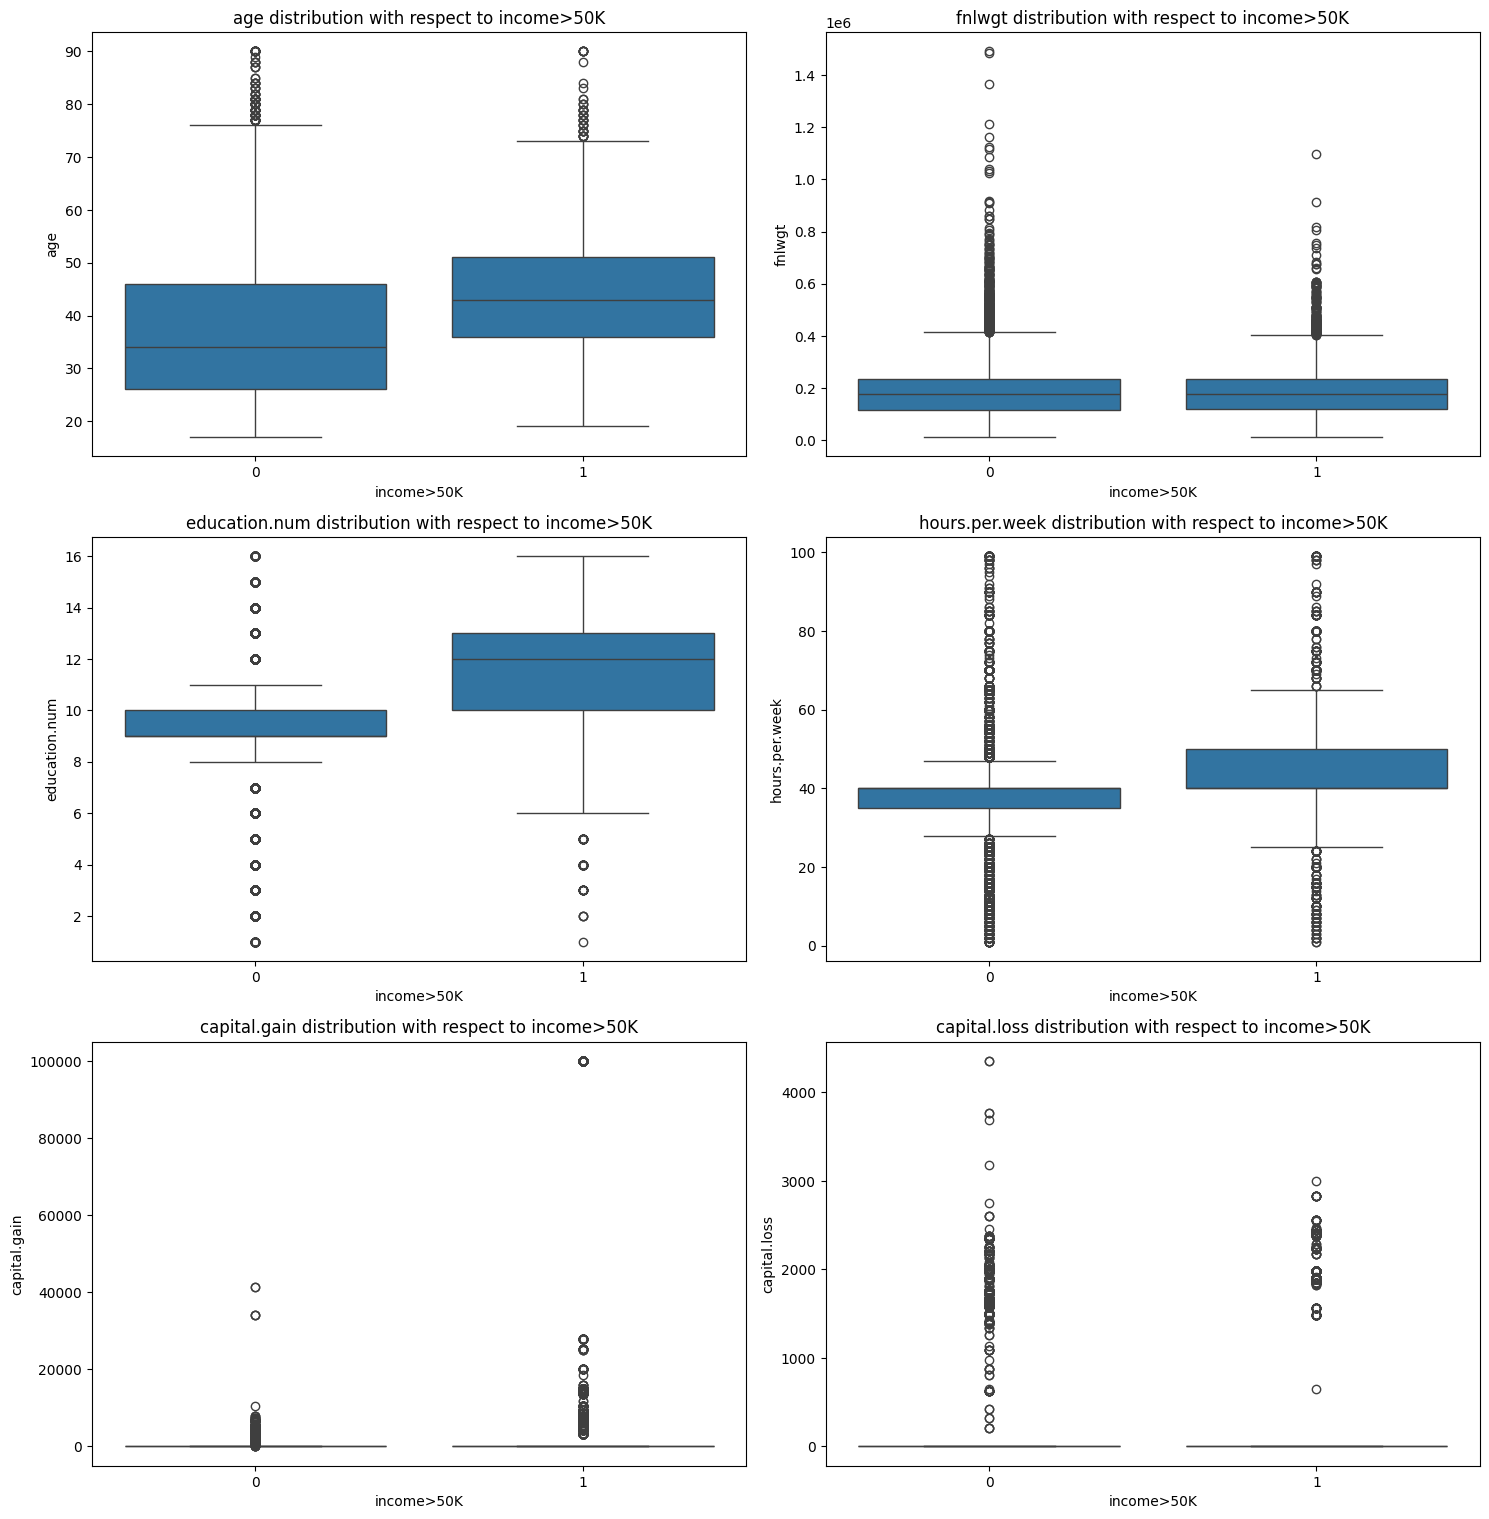

In [ ]:
plot_numerical_with_income(train_data, numerical_columns, 'income>50K')

**Handling Categorical Vairable**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Function for Frequency Encoding
def frequency_encode_columns(train, test, columns):
    for column in columns:
        freq = train[column].value_counts() / len(train)  # Calculate frequencies in the training set
        train[column] = train[column].map(freq)           # Replace the original column in the train set
        test[column] = test[column].map(freq)             # Replace the original column in the test set

        # Handle NaN values in the test set where the category wasn't present in the training set
        test[column] = test[column].fillna(0)
    return train, test

# Function for Label Encoding
def label_encode_columns(train, test, columns):
    label_encoder = LabelEncoder()  # Initialize LabelEncoder
    for column in columns:
        train[column] = label_encoder.fit_transform(train[column])  # Fit and transform train
        test[column] = label_encoder.transform(test[column])        # Transform test
    return train, test

# Combined function to choose encoding type
def encode_columns(train, test, binary_columns, multi_valued_columns, encoding_type='label'):
    if encoding_type == 'label':
        # Apply Label Encoding for both binary and multi-valued columns
        train, test = label_encode_columns(train, test, binary_columns + multi_valued_columns)
    elif encoding_type == 'frequency':
        # Apply Frequency Encoding for multi-valued columns
        train, test = frequency_encode_columns(train, test, multi_valued_columns)
        # Apply Label Encoding for binary columns (as they are not multi-valued)
        train, test = label_encode_columns(train, test, binary_columns)
    else:
        raise ValueError("Invalid encoding_type. Choose 'label' or 'frequency'.")
    return train, test


binary_columns = ['sex']
multi_valued_columns = ['workclass', 'education', 'race', 'marital.status', 'relationship', 'occupation', 'native.country']

# Choose 'label' for Label Encoding or 'frequency' for Frequency Encoding
encoding_type = 'frequency'  # Options: 'label', 'frequency'

# Apply the encoding
train_data, test_data = encode_columns(train_data, test_data, binary_columns, multi_valued_columns, encoding_type)



**Feature Selection Using Random Forest**

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import numpy as np

def find_important_features(df, target_column, variance_threshold=0.01, top_n=10):
    # Step 1: Remove low variance features
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Variance threshold to remove low variance features
    selector = VarianceThreshold(threshold=variance_threshold)
    X_var = selector.fit_transform(X)

    # Get the feature names after variance thresholding
    retained_columns = X.columns[selector.get_support()]

    # Step 2: Correlation with Target
    correlations = {}
    for col in retained_columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            correlations[col] = np.corrcoef(df[col], y)[0, 1]  # Pearson correlation

    # Sort features by absolute correlation values
    sorted_by_correlation = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

    # Step 3: Model-based Feature Importance using Random Forest
    X_train, X_test, y_train, y_test = train_test_split(df[retained_columns], y, test_size=0.2, random_state=42)

    # Train a Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Get feature importances
    feature_importances = rf.feature_importances_

    # Create a DataFrame to combine correlation and importance
    feature_stats = pd.DataFrame({
        'Feature': retained_columns,
        'Correlation': [correlations[col] if col in correlations else 0 for col in retained_columns],
        'Importance': feature_importances
    })

    # Rank the features based on importance
    feature_stats['Combined_Rank'] = feature_stats['Importance'].rank(ascending=False)

    # Sort by combined rank or importance
    important_features = feature_stats.sort_values('Combined_Rank').head(top_n)

    return important_features['Feature']


important_features = find_important_features(train_data, target_column='income>50K', top_n=10)
print(important_features)

2             fnlwgt
0                age
9       capital.gain
5     marital.status
4      education.num
11    hours.per.week
6       relationship
1          workclass
10      capital.loss
3          education
Name: Feature, dtype: object


**Classification**

**1.1 Support Vector Machine with RBF**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score ,confusion_matrix

# Assuming train_data contains both features and the target column 'income>50K'

# Separate the features and the target variable
X = train_data[important_features] # Features (drop the target column)
y = train_data['income>50K']  # Target variable

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (important for SVMs with RBF kernel)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


model=SVC(kernel='rbf',C=10,gamma=0.1,probability=True,class_weight='balanced')
model.fit(X_train_scaled,y_train)

# Set up the parameter grid for C and gamma
"""
param_grid = [
    {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},  # For RBF kernel

]
# Initialize GridSearchCV with the SVM model
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid_search.fit(X_train_scaled, y_train)
"""

#Print the best parameters from GridSearchCV
#print("Best Parameters from Grid Search:", grid_search.best_params_)


# Use the best model to make predictions on the validation set
y_pred= model.predict(X_val_scaled)

# Evaluate the best model
print("Accuracy with Tuned Parameters:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


Accuracy with Tuned Parameters: 0.7948
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.77      0.85      3782
           1       0.55      0.87      0.67      1218

    accuracy                           0.79      5000
   macro avg       0.75      0.82      0.76      5000
weighted avg       0.85      0.79      0.81      5000

Confusion Matrix:
 [[2917  865]
 [ 161 1057]]


**AUC Curve for SVM**

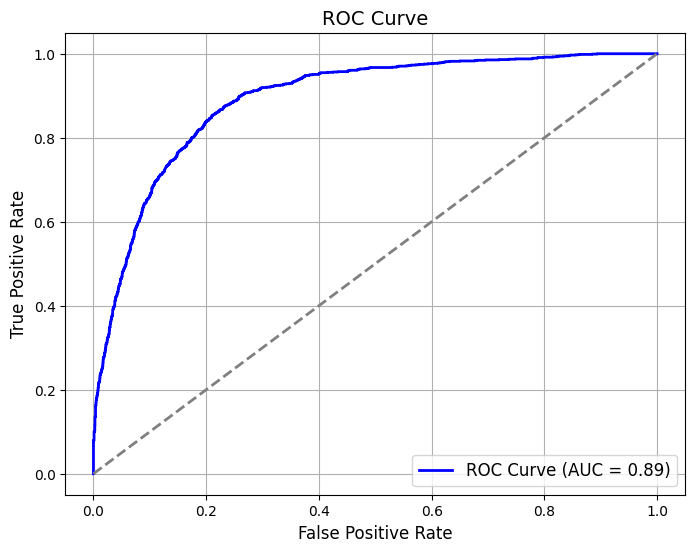

AUC Score: 0.8918087275392295


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Generate the predicted probabilities for the positive class (income > 50K)
y_prob = model.predict_proba(X_val_scaled)[:, 1]  # Probability of the positive class

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_val, y_prob)  # False positive rate, True positive rate
roc_auc = auc(fpr, tpr)  # Compute the AUC score

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()

# Print AUC score for reference
print("AUC Score:", roc_auc)


**1.2 XGBoost Classifer**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

# Assuming train_data contains both features and the target column 'income>50K'

# 1. Separate the features and the target variable
X = train_data.drop('income>50K', axis=1)  # Features (drop the target column)
y = train_data['income>50K']  # Target variable

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (optional but often beneficial for tree-based models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Calculate scale_pos_weight to handle class imbalance
# Formula: scale_pos_weight = (number of negative samples) / (number of positive samples)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize XGBoost classifier with class imbalance handling
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight,gamma=0.1,learning_rate=0.2, max_depth=7, n_estimators=200)
"""
# 6. Set up the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.3]
}
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
# Initialize GridSearchCV with XGBoost model
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_
# Print the best parameters
print("Best Parameters from Grid Search:", grid_search.best_params_)
# 9. Use the best model to make predictions on the validation set
"""
xgb_model.fit(X_train_scaled,y_train)
y_pred = xgb_model.predict(X_val_scaled)

# 10. Evaluate the best model
print("Accuracy with Tuned Parameters:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy with Tuned Parameters: 0.8406
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89      3782
           1       0.64      0.81      0.71      1218

    accuracy                           0.84      5000
   macro avg       0.78      0.83      0.80      5000
weighted avg       0.86      0.84      0.85      5000



**AUC Curve FOR XGBoost Classifier**

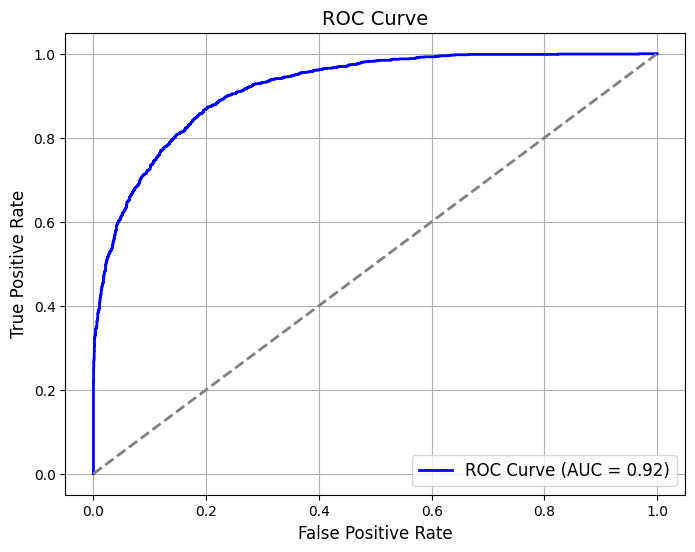

AUC Score: 0.9192976366315595


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Generate the predicted probabilities for the positive class (income > 50K)
y_prob = xgb_model.predict_proba(X_val_scaled)[:, 1]  # Probability of the positive class

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_val, y_prob)  # False positive rate, True positive rate
roc_auc = auc(fpr, tpr)  # Compute the AUC score

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()

# Print AUC score for reference
print("AUC Score:", roc_auc)

**Artificial Neural Network**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

# Assuming train_data contains both features and the target column 'income>50K'

# 1. Separate the features and the target variable
X = train_data.drop('income>50K', axis=1)  # Features (drop the target column)
y = train_data['income>50K']   # Target variable

# 2. Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 4. Calculate class weights to handle class imbalance
class_weight = {
    0: len(y_train) / (2 * len(y_train[y_train == 0])),
    1: len(y_train) / (2 * len(y_train[y_train == 1])),
}

# Define the model with an Input layer
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Specify input shape here

    # First hidden layer
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Second hidden layer
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Third hidden layer
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output layer
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 8. Train the model
print(X_train_scaled.shape)
print(y_train.shape)
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,  # Increased epochs for the complex model
    batch_size=16,
    #validation_data=(X_val_scaled, y_val),
    #class_weight=class_weight,  # Handle class imbalance
    #callbacks=[early_stopping],
    verbose=1
)

# 9. Evaluate the model
y_pred = (model.predict(X_val_scaled) > 0.5).astype(int)


print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


(20000, 14)
(20000,)
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7498 - loss: 0.5141
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8204 - loss: 0.3875
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8259 - loss: 0.3728
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8352 - loss: 0.3463
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8290 - loss: 0.3555
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8355 - loss: 0.3516
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8334 - loss: 0.3548
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8367 - loss: 0.3466
Epoch 9/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8376 - loss: 0.3493
Epoch 10/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8383 - loss: 0.3428
Epoch 11/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8393 - loss: 0.342

**Neural Network with SoftMax Activation**


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

# Assuming train_data contains both features and the target column 'income>50K'

# 1. Separate the features and the target variable
X = train_data[important_features]  # Replace with selected features
y = train_data['income>50K']  # Target variable

# 2. Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 4. Calculate class weights to handle class imbalance
class_weight = {
    0: len(y_train) / (2 * len(y_train[y_train == 0])),
    1: len(y_train) / (2 * len(y_train[y_train == 1])),
}



# Define the model with an Input layer
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Specify input shape here

    # First hidden layer
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    #Second Hidden Layer

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Third hidden layer
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Fourth hidden layer
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output layer
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 8. Train the model
print(X_train_scaled.shape)
print(y_train.shape)
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,  # Increased epochs for the complex model
    batch_size=16,
    #validation_data=(X_val_scaled, y_val),
    #class_weight=class_weight,  # Handle class imbalance
    #callbacks=[early_stopping],
    verbose=1
)

# 9. Evaluate the model
y_pred = (model.predict(X_val_scaled) > 0.5).astype(int)


print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


(20000, 10)
(20000,)
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7280 - loss: 0.5275
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8188 - loss: 0.3768
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8255 - loss: 0.3596
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8346 - loss: 0.3585
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8351 - loss: 0.3585
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8335 - loss: 0.3523
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8431 - loss: 0.3400
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8373 - loss: 0.3484
Epoch 9/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8367 - loss: 0.3534
Epoch 10/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8400 - loss: 0.3487
Epoch 11/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8376 - loss: 0.35

**CNN1D**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
# Assuming train_data contains both features and the target column 'income>50K'

# 1. Separate the features and the target variable
X = train_data[important_features]  # Replace with selected features
y = train_data['income>50K']  # Target variable

# 2. Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 4. Calculate class weights to handle class imbalance
class_weight = {
    0: len(y_train) / (2 * len(y_train[y_train == 0])),
    1: len(y_train) / (2 * len(y_train[y_train == 1])),
}


# Define a 1D CNN model
cnn_model = Sequential([
    Input(shape=(X_train_scaled.shape[1], 1)),  # Input for 1D CNN requires an additional dimension

    # First convolutional block
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Second convolutional block
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Flatten the output
    Flatten(),

    # Fully connected dense layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),

    # Output layer
    Dense(1, activation='sigmoid')  # Binary classification
])




# Compile the model
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
cnn_model.summary()
history = cnn_model.fit(
    X_train_scaled,
    y_train,
    epochs=100,  # Increased epochs for the complex model
    batch_size=16,
    #validation_data=(X_val_scaled, y_val),
    #class_weight=class_weight,  # Handle class imbalance
    #callbacks=[early_stopping],
    verbose=1
)

# 9. Evaluate the model
y_pred = (cnn_model.predict(X_val_scaled) > 0.5).astype(int)


print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 10, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 5, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 5, 64)               │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 5, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,553 (123.25 KB)

 Trainable params: 31,361 (122.50 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7978 - loss: 0.4291
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8279 - loss: 0.3626
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8329 - loss: 0.3560
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8346 - loss: 0.3528
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8408 - loss: 0.3462
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8434 - loss: 0.3375
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8439 - loss: 0.3426
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8408 - loss: 0.3446
Epoch 9/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8435 - loss: 0.3362
Epoch 10/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8448 - loss: 0.3374
Epoch 11/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8411 - loss: 0.3413
Epoch 12/100
1250/1

In [ ]:
test_ids=test_data['ID'].values
testing_data=test_data.drop(columns=['ID'])
testing_data=test_data.drop(columns=['ID'])
testing_data=testing_data[important_features]
X_test=testing_data.to_numpy()

scaler = StandardScaler()
# Fit and transform the test data
test_data_normalized = scaler.fit_transform(X_test)

#For Neural Netwok
predictions=cnn_model.predict(test_data_normalized)

746/746 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
print(predictions)

[[0.23972715]
 [0.01192711]
 [0.22892062]
 ...
 [0.9998657 ]
 [0.09174768]
 [0.08895054]]


In [ ]:
predictions = np.squeeze(predictions)

In [ ]:
print(predictions)

[0.23972715 0.01192711 0.22892062 ... 0.9998657  0.09174768 0.08895054]


In [ ]:
print(test_ids)

[    1     2     3 ... 23840 23841 23842]


In [ ]:
#Saving the Submission
my_submission = pd.DataFrame({'ID': test_ids,
                             'Prediction': predictions})
my_submission.to_csv('submission2.csv', index=False)